# data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import datetime, math

In [2]:
# def load_data(filename):
#     data = pd.read_csv(filename, sep=',', parse_dates=[['<DATE>', '<TIME>']])
#     data.columns = map(lambda x: x.replace('<', '').replace('>', '').lower(), data.columns)
#     data = data.rename({'date_time': 'date', 'vol': 'volume'}, axis=1)
#     #data = data.set_index('date')
#     return data

In [3]:
def _load_df(name, date, path=None):
    if path is not None:
        path = path.rstrip('/') + '/'
    else:
        path = ''
    data = pd.read_csv(f'{path}{name}_{date}.csv', sep=',', parse_dates=[['<DATE>', '<TIME>']])
    data.columns = map(lambda x: x.replace('<', '').replace('>', '').lower(), data.columns)
    if name == 'USD000000TOD':
        name = 'USD'
    if name == 'ICE.BRN':
        name = 'BRN'
    if name == 'SANDP-500':
        name = 'SNP'
    for i in ['ticker', 'per']:
        try:
            data = data.drop(i, axis=1)
        except KeyError:
            pass
    data.columns = [column+('_'+name.lower())*bool(column not in ['date_time', 'date', 'time']) for column in data.columns]
    data = data.rename({'date_time': 'date', 'vol': 'volume'}, axis=1)
    #data = data.set_index('date')
    return data

def load_data(names, dates):
    from functools import reduce
    df_list = [pd.concat([_load_df(n, d) for d in dates]) for n in names]
    return reduce(lambda df1, df2: pd.merge(df1, df2, how='inner'), df_list)

In [4]:
names=['GAZP', 'USD000000TOD', 'ICE.BRN', 'IMOEX']
dates=['131101_151031', '151101_171031', '171101_191031']
data = load_data(names, dates)

In [5]:
for i in ['gazp', 'usd', 'brn', 'imoex']:
    data[f'return_{i}'] = (data[f'close_{i}'] - data.shift()[f'close_{i}']) / data.shift()[f'close_{i}']

In [7]:
data['time_norm'] = 2 * math.pi * (data.date.dt.hour * 60 + data.date.dt.minute) / (24*60)
data['time_cos'] = np.cos(data['time_norm'])
data['time_sin'] = np.sin(data['time_norm'])
data = data.drop('time_norm', axis=1)

In [8]:
data['dayofweek_norm'] = 2 * math.pi * data.date.dt.dayofweek / 7
data['dayofweek_cos'] = np.cos(data['dayofweek_norm'])
data['dayofweek_sin'] = np.sin(data['dayofweek_norm'])
data = data.drop('dayofweek_norm', axis=1)

In [9]:
data['dayofweek'] = data.date.dt.dayofweek
data = pd.get_dummies(data, columns=['dayofweek'])

In [10]:
data.head()

,date,open_gazp,high_gazp,low_gazp,close_gazp,vol_gazp,open_usd,high_usd,low_usd,close_usd,...,return_imoex,time_cos,time_sin,dayofweek_cos,dayofweek_sin,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4
0,2013-12-04 10:05:00,139.06,139.25,138.91,139.15,462810,33.230,33.2775,33.225,33.2585,...,NaN,-0.876727,0.480989,-0.222521,0.974928,0,0,1,0,0
1,2013-12-04 10:10:00,139.21,139.26,138.94,139.24,567420,33.255,33.2655,33.255,33.2610,...,-0.000200,-0.887011,0.461749,-0.222521,0.974928,0,0,1,0,0
2,2013-12-04 10:15:00,139.23,139.30,139.01,139.10,659230,33.260,33.2650,33.257,33.2590,...,0.000441,-0.896873,0.442289,-0.222521,0.974928,0,0,1,0,0
3,2013-12-04 10:20:00,139.15,139.40,139.15,139.25,452680,33.260,33.2600,33.250,33.2570,...,-0.000172,-0.906308,0.422618,-0.222521,0.974928,0,0,1,0,0
4,2013-12-04 10:25:00,139.25,139.30,139.01,139.19,307740,33.257,33.2585,33.253,33.2570,...,-0.000379,-0.915311,0.402747,-0.222521,0.974928,0,0,1,0,0


In [18]:
#plt.plot(data['close'])

In [19]:
#plt.plot(data['return'])

In [20]:
# data_day = data.groupby(data.index.date).aggregate({
#     'ticker': 'first',
#     'return': lambda x: np.prod(x+1)-1, 
#     'volume': 'sum', 
#     'open': 'first', 
#     'close': 'last'
#     })
# data_day['volatility'] = data.groupby(data.index.date).aggregate({'return': lambda x: np.sqrt((x**2).sum())})
# data_day.index = pd.DatetimeIndex(data_day.index)

In [21]:
# data_day['close'].plot()

In [22]:
# data_day['return'].plot()

In [23]:
# data_day['volatility'].plot()

In [24]:
# data_day['volume'].plot()

In [25]:
# data_day = data_day[data_day.index < pd.to_datetime('2020-01-01')]

In [26]:
# data_day.head()

In [27]:
# data_day['weekday'] = data_day.index.dayofweek
# data_day = pd.get_dummies(data_day, columns=['weekday'])
# data_day = data_day.drop('weekday_5', axis=1)

# lstm model

In [28]:
data = data[1:]
data = data.set_index('date')

In [29]:
config = {
    'seq_length': 30,
    'batch_size': 256,
    'learning_rate': 0.001,
    'weight_decay': 0.001,
    'num_layers': 2,
    'hidden_size': 512,
    'epochs': 50
}

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [31]:
%load_ext autoreload
%autoreload 2

In [32]:
from utils import *
from models import *

In [33]:
torch.manual_seed(1)

## dataloaders

In [34]:
#data = pd.read_csv('https://raw.githubusercontent.com/KurochkinAlexey/DA-RNN/master/nasdaq100_padding.csv')

In [35]:
exclude = ['time_cos', 'time_sin', 'dayofweek_cos', 'dayofweek_sin', 
           'dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4']
norm_stats = calculate_normalization_statictics(data, train_size=0.6, exclude=exclude)

In [36]:
dataset = TickerDataset(data, y='close_gazp', seq_length=config['seq_length'], norm_stats=norm_stats)
train_dataset, val_dataset, test_dataset = sequential_split(dataset, splits=[0.6, 0.2, 0.2])

In [37]:
full_loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

## training

In [38]:
from models import *
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [39]:
# model = BasicLSTM(
#     input_size=dataset.data.shape[1], 
#     seq_length=config['seq_length'],
#     num_layers=config['num_layers'], 
#     hidden_size=config['hidden_size'])

In [40]:
model = DARNN_(
    N=dataset.data.shape[1],
    M=256,
    P=256,
    T=config['seq_length'])

In [41]:
trainer = ModelTrainer(model)
trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=0.001, weight_decay=0.001)
trainer.sceduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=0.99)

In [42]:
trainer.fit(train_loader, val_loader, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

1 epoch:


  0%|          | 0/289 [00:00<?, ?it/s]

train loss 0.023003640549602213
train <lambda> 2300.3640849301173


  0%|          | 0/97 [00:00<?, ?it/s]

valid loss 0.0011104426633106958
train <lambda> 111.04426728369495
--------------------------------------------------------------------------------
2 epoch:


  0%|          | 0/289 [00:00<?, ?it/s]

KeyboardInterrupt: 

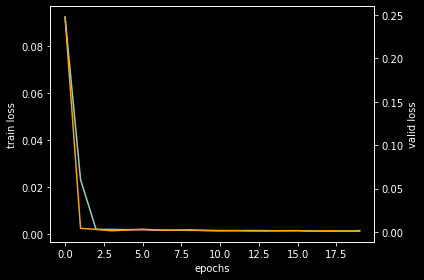

In [112]:
trainer.plot_loss();

In [135]:
mean_squared_error(
    (data['close_gazp'][config['seq_length']+len(train_dataset):-len(test_dataset)+1].to_numpy() - np.array(norm_stats)[0][3]) / np.array(norm_stats)[1][3], 
    (data['close_gazp'].shift()[config['seq_length']+len(train_dataset):-len(test_dataset)+1].to_numpy() - np.array(norm_stats)[0][3]) / np.array(norm_stats)[1][3]
) * 1e5

5.286784676069917

In [ ]:
# this essentially. the whole model is a complete grabage because previous item baseline vastly outperforms it.
# but anyway it is probably the wrong use of the model, it needs a lot of *exogenous* variables
# maybe makes sense to check on s&p firstly
# and also try to find other models

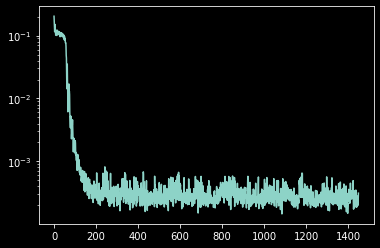

In [136]:
plt.plot(trainer.logs['train_step_loss'])
plt.yscale('log')

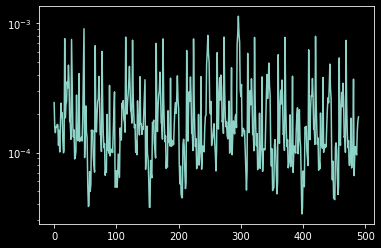

In [137]:
plt.plot(trainer.logs['valid_step_loss'])
plt.yscale('log')

# prediciton

In [138]:
full_preds, x_attentions, t_attentions = trainer.predict(full_loader)
full_preds = full_preds * np.array(norm_stats)[1][3] + np.array(norm_stats)[0][3]

  0%|          | 0/241 [00:00<?, ?it/s]

In [139]:
x_attentions = x_attentions.mean(1)

In [140]:
t_attentions = t_attentions.mean(1)

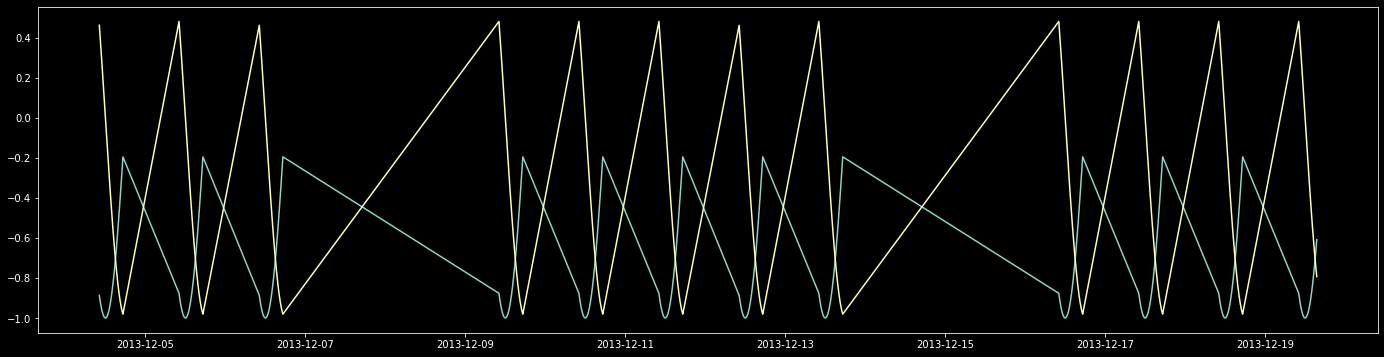

In [141]:
plt.figure(figsize=(24, 6))
plt.plot(data['time_cos'][:1000])
plt.plot(data['time_sin'][:1000])

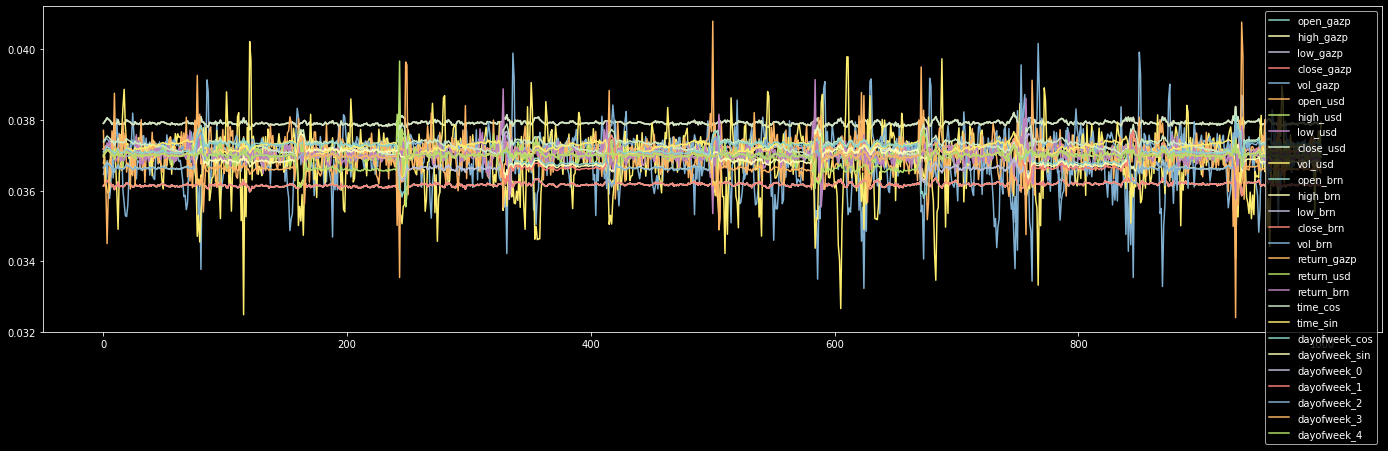

In [142]:
plt.figure(figsize=(24, 6))
plt.plot(x_attentions[:1000])
plt.legend(data.columns)

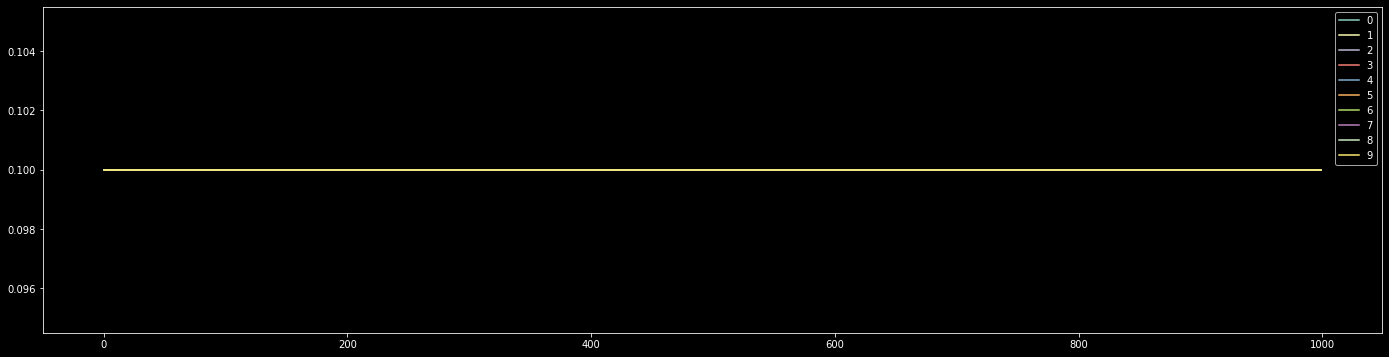

In [143]:
plt.figure(figsize=(24, 6))
plt.plot(t_attentions[:1000])
plt.legend(range(10))

In [144]:
data.loc[config['seq_length']:-1, 'predictions'] = full_preds

c:\python39\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


In [145]:
data['return_pred'] = (data['predictions'] - data.shift()['predictions']) / data.shift()['predictions']

In [146]:
data['return_pred_vs_actual'] = (data['predictions'] - data.shift()['close_gazp']) / data.shift()['close_gazp']

In [147]:
def plot_preds(y_pred, y_true, splits=None):
    fig = plt.figure(figsize=(24,6))
    plt.plot(y_true)
    plt.plot(y_pred)
    if splits is not None:
        plt.axvline(x=splits[0], color='r', linestyle='--')
        plt.axvline(x=splits[1], color='r', linestyle='--')
    return fig

Text(0.5, 1.0, 'Predictions against target, full dataset')

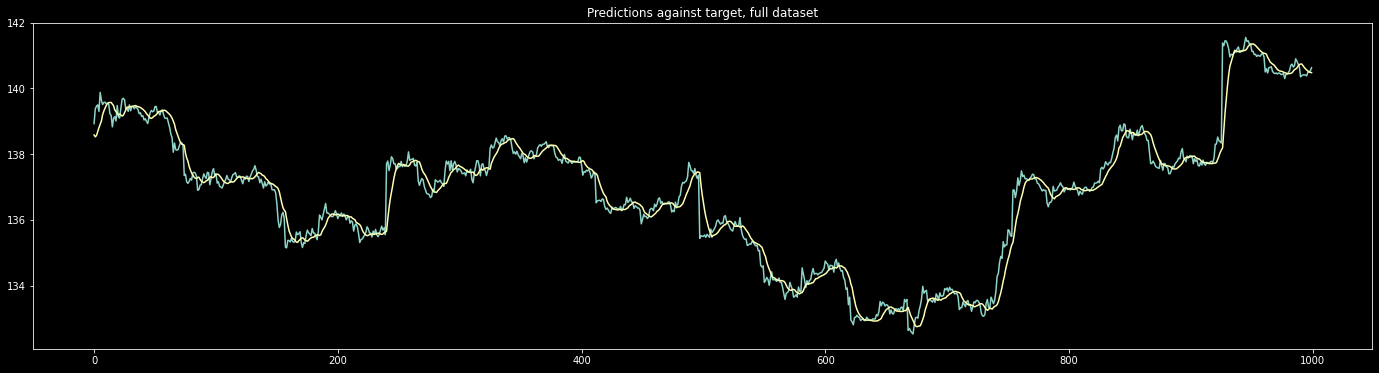

In [148]:
fig = plot_preds(full_preds[:1000], data.iloc[:, 3][config['seq_length']:1010].to_numpy())#, splits=(len(train_dataset), len(train_dataset)+len(val_dataset)))
plt.title('Predictions against target, full dataset')

Text(0.5, 1.0, 'Predictions against target, full dataset')

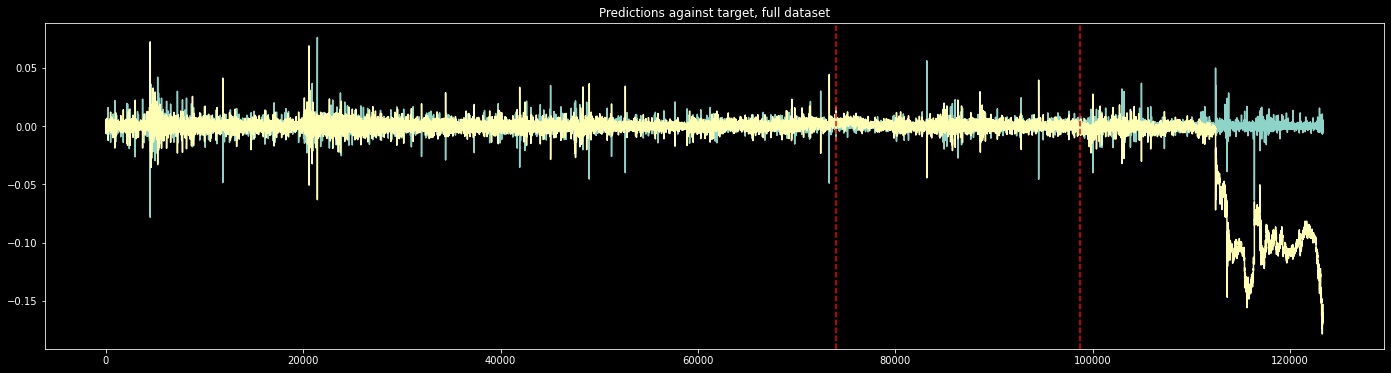

In [149]:
fig = plot_preds(
    data['return_pred_vs_actual'][config['seq_length']:].to_numpy(), 
    data['return_gazp'][config['seq_length']:].to_numpy(), 
    splits=(len(train_dataset), len(train_dataset)+len(val_dataset)))
plt.title('Predictions against target, full dataset')

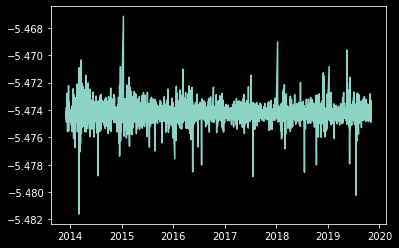

In [100]:
plt.plot((data['return_gazp'] - np.array(norm_stats)[0][5]) / np.array(norm_stats)[1][5])

In [152]:
mean_squared_error(
    (data['return_pred_vs_actual'][config['seq_length']+len(train_dataset):-len(test_dataset)+1].to_numpy() - np.array(norm_stats)[0][5]) / np.array(norm_stats)[1][5], 
    (data['return_gazp'][config['seq_length']+len(train_dataset):-len(test_dataset)+1].to_numpy() - np.array(norm_stats)[0][5]) / np.array(norm_stats)[1][5]
)

7.440710613957586e-08

In [102]:
(data['return_pred_vs_actual'][config['seq_length']+len(train_dataset):-len(test_dataset)+1].to_numpy() - np.array(norm_stats)[0][5]) / np.array(norm_stats)[1][5]

array([-5.47461691, -5.4745441 , -5.47322134, ..., -5.47437701,
       -5.47440843, -5.47443562])

Text(0.5, 1.0, 'Predictions against target, full dataset')

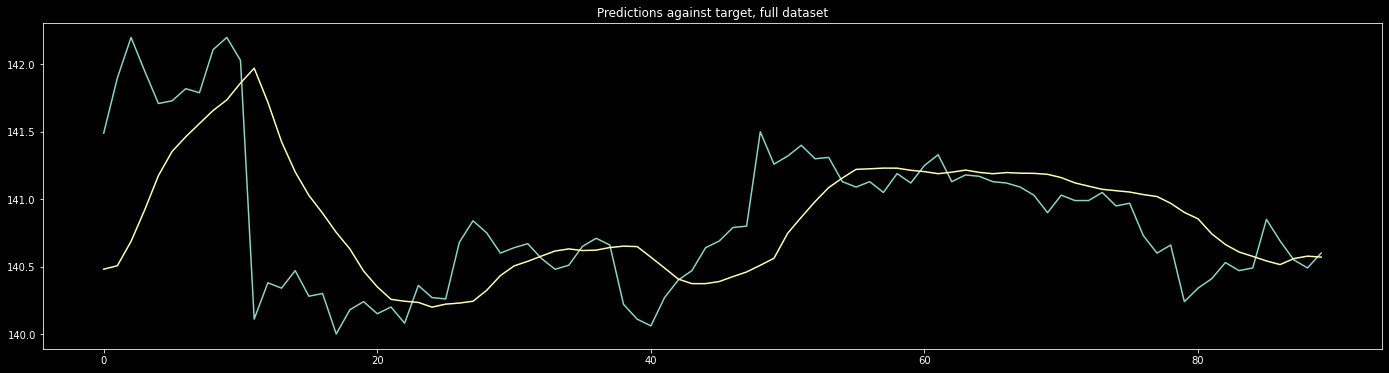

In [154]:
fig = plot_preds(data['predictions'][config['seq_length']+1000:1100].to_numpy(), data['close_gazp'][config['seq_length']+1000:1100].to_numpy())
plt.title('Predictions against target, full dataset')

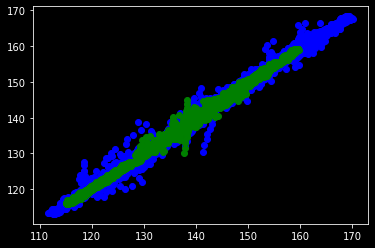

In [153]:
plt.scatter(
    data['close_gazp'][config['seq_length']:config['seq_length']+len(train_dataset)].to_numpy(), 
    data['predictions'][config['seq_length']:config['seq_length']+len(train_dataset)].to_numpy(),
    color='blue')
plt.scatter(
    data['close_gazp'][config['seq_length']+len(train_dataset):config['seq_length']+len(train_dataset)+len(val_dataset)].to_numpy(), 
    data['predictions'][config['seq_length']+len(train_dataset):config['seq_length']+len(train_dataset)+len(val_dataset)].to_numpy(),
    color='green')
# plt.scatter(
#     data['close'][config['seq_length']+len(train_dataset)+len(val_dataset):].to_numpy(), 
#     data['predictions'][config['seq_length']+len(train_dataset)+len(val_dataset):].to_numpy(),
#     color='red')

In [228]:
val_preds = trainer.predict(val_loader) * np.array(norm_stats)[1] + np.array(norm_stats)[0]
test_preds = trainer.predict(test_loader) * np.array(norm_stats)[1] + np.array(norm_stats)[0]

Text(0.5, 1.0, 'Predictions against target')

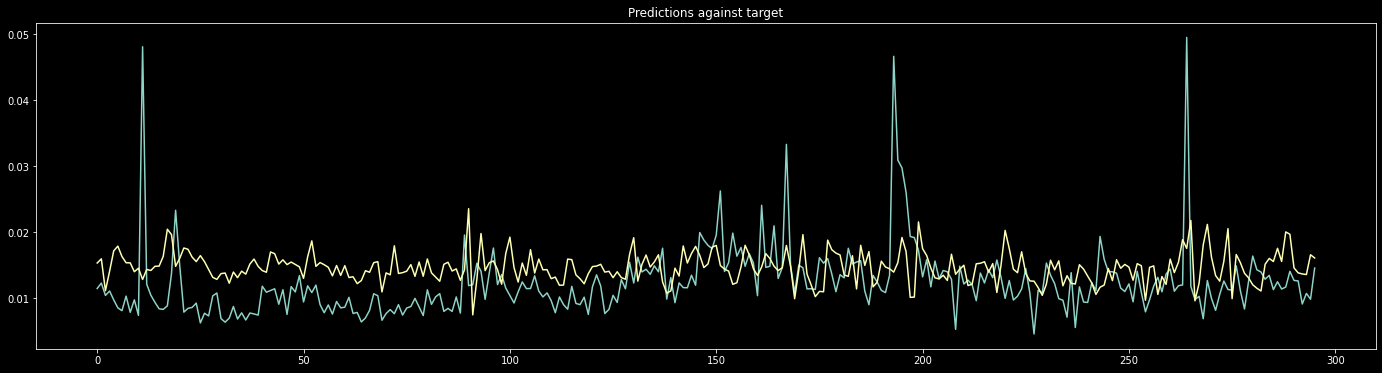

In [229]:
fig = plot_preds(val_preds[:, 4], data['volatility'][len(train_dataset)+config['seq_length']:len(train_dataset)+len(val_dataset)+config['seq_length']].to_numpy())
plt.title('Predictions against target')

In [ ]:
print('Validation')
print('previous item MSE |', mean_squared_error(val_dataset.y[SEQ_LENGTH:], val_dataset.X[SEQ_LENGTH:, 0]))
print('train mean MSE    |', mean_squared_error(val_dataset.y[SEQ_LENGTH:], np.repeat(train_target.mean(), len(val_dataset))))
print('validation MSE    |', mean_squared_error(val_dataset.y[SEQ_LENGTH:], val_preds))

Validation
previous item MSE | 0.75418323
train mean MSE    | 0.7425473620650748
validation MSE    | 3.0327671648757084


# xgb

In [ ]:
import xgboost

In [ ]:
xgb = xgboost.XGBRegressor(max_depth=10, objective='reg:squarederror', n_estimators=1000)

In [ ]:
xgb.fit(train_data_, train_target)

XGBRegressor(max_depth=10, n_estimators=1000, objective='reg:squarederror')

In [ ]:
train_data_

,volatility,return,volume,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,volatility_lag_1,volatility_lag_2,volatility_lag_3,volatility_lag_4,volatility_lag_5,volatility_lag_6,volatility_lag_7,volatility_lag_8,volatility_lag_9,volatility_lag_10,volatility_lag_11,volatility_lag_12,volatility_lag_13,volatility_lag_14,volatility_lag_15,volatility_lag_16,volatility_lag_17,volatility_lag_18,volatility_lag_19,volatility_lag_20,volatility_lag_21,volatility_lag_22,volatility_lag_23,volatility_lag_24,volatility_lag_25,volatility_lag_26,volatility_lag_27,volatility_lag_28,volatility_lag_29,volatility_lag_30,return_lag_1,...,return_lag_21,return_lag_22,return_lag_23,return_lag_24,return_lag_25,return_lag_26,return_lag_27,return_lag_28,return_lag_29,return_lag_30,volume_lag_1,volume_lag_2,volume_lag_3,volume_lag_4,volume_lag_5,volume_lag_6,volume_lag_7,volume_lag_8,volume_lag_9,volume_lag_10,volume_lag_11,volume_lag_12,volume_lag_13,volume_lag_14,volume_lag_15,volume_lag_16,volume_lag_17,volume_lag_18,volume_lag_19,volume_lag_20,volume_lag_21,volume_lag_22,volume_lag_23,volume_lag_24,volume_lag_25,volume_lag_26,volume_lag_27,volume_lag_28,volume_lag_29,volume_lag_30
2013-11-01,0.007140,-0.002520,34581210,0,0,0,0,1,0,0.015340,0.015343,0.015344,0.015349,0.015350,0.015354,0.015358,0.015360,0.015359,0.015357,0.015360,0.015367,0.015373,0.015379,0.015384,0.015389,0.015394,0.015397,0.015394,0.015385,0.015391,0.015392,0.015381,0.015386,0.015389,0.015392,0.015396,0.015395,0.015393,0.015399,-0.000167,...,-0.000028,-0.000025,-0.000017,-0.000029,-0.000003,-9.139076e-07,0.000003,0.000011,0.000017,0.000019,3.765267e+07,3.764231e+07,3.764961e+07,3.766776e+07,3.767905e+07,3.768996e+07,3.771167e+07,3.772610e+07,3.772550e+07,3.771340e+07,3.769363e+07,3.771785e+07,3.773271e+07,3.774964e+07,3.776447e+07,3.777068e+07,3.777451e+07,3.777291e+07,3.775046e+07,3.770259e+07,3.772532e+07,3.774254e+07,3.773277e+07,3.774849e+07,3.774979e+07,3.776576e+07,3.777892e+07,3.778557e+07,3.779088e+07,3.779543e+07
2013-11-05,0.009304,-0.011699,36999370,0,1,0,0,0,0,0.007140,0.015343,0.015344,0.015349,0.015350,0.015354,0.015358,0.015360,0.015359,0.015357,0.015360,0.015367,0.015373,0.015379,0.015384,0.015389,0.015394,0.015397,0.015394,0.015385,0.015391,0.015392,0.015381,0.015386,0.015389,0.015392,0.015396,0.015395,0.015393,0.015399,-0.002520,...,-0.000028,-0.000025,-0.000017,-0.000029,-0.000003,-9.139076e-07,0.000003,0.000011,0.000017,0.000019,3.458121e+07,3.764231e+07,3.764961e+07,3.766776e+07,3.767905e+07,3.768996e+07,3.771167e+07,3.772610e+07,3.772550e+07,3.771340e+07,3.769363e+07,3.771785e+07,3.773271e+07,3.774964e+07,3.776447e+07,3.777068e+07,3.777451e+07,3.777291e+07,3.775046e+07,3.770259e+07,3.772532e+07,3.774254e+07,3.773277e+07,3.774849e+07,3.774979e+07,3.776576e+07,3.777892e+07,3.778557e+07,3.779088e+07,3.779543e+07
2013-11-06,0.010938,-0.009551,45785890,0,0,1,0,0,0,0.009304,0.007140,0.015344,0.015349,0.015350,0.015354,0.015358,0.015360,0.015359,0.015357,0.015360,0.015367,0.015373,0.015379,0.015384,0.015389,0.015394,0.015397,0.015394,0.015385,0.015391,0.015392,0.015381,0.015386,0.015389,0.015392,0.015396,0.015395,0.015393,0.015399,-0.011699,...,-0.000028,-0.000025,-0.000017,-0.000029,-0.000003,-9.139076e-07,0.000003,0.000011,0.000017,0.000019,3.699937e+07,3.458121e+07,3.764961e+07,3.766776e+07,3.767905e+07,3.768996e+07,3.771167e+07,3.772610e+07,3.772550e+07,3.771340e+07,3.769363e+07,3.771785e+07,3.773271e+07,3.774964e+07,3.776447e+07,3.777068e+07,3.777451e+07,3.777291e+07,3.775046e+07,3.770259e+07,3.772532e+07,3.774254e+07,3.773277e+07,3.774849e+07,3.774979e+07,3.776576e+07,3.777892e+07,3.778557e+07,3.779088e+07,3.779543e+07
2013-11-07,0.016914,0.020780,69806330,0,0,0,1,0,0,0.010938,0.009304,0.007140,0.015349,0.015350,0.015354,0.015358,0.015360,0.015359,0.015357,0.015360,0.015367,0.015373,0.015379,0.015384,0.015389,0.015394,0.015397,0.015394,0.015385,0.015391,0.015392,0.015381,0.015386,0.015389,0.015392,0.015396,0.015395,0.015393,0.015399,-0.009551,...,-0.000

In [ ]:
preds = xgb.predict(test_data_)

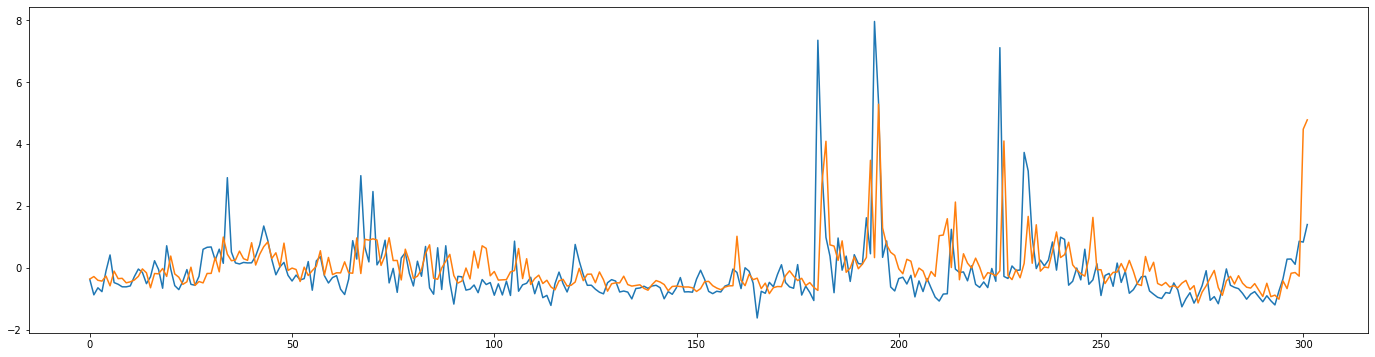

In [ ]:
plt.figure(figsize=(24,6))
plt.plot(test_target.values)
#plt.plot(prediction_test)
plt.plot(preds)

In [ ]:
mean_squared_error(test_target, preds)

1.2604208653757925

# arima

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [ ]:
result = adfuller(target[:].values.T[0])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.592569
p-value: 0.000000


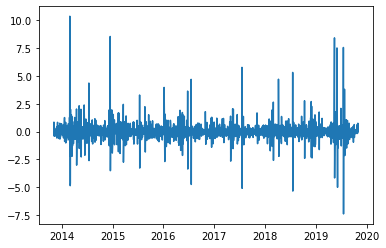

In [ ]:
plt.plot(target.diff())

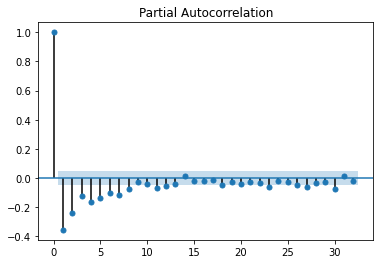

In [ ]:
pacf = plot_pacf(target.diff(1)[1:])

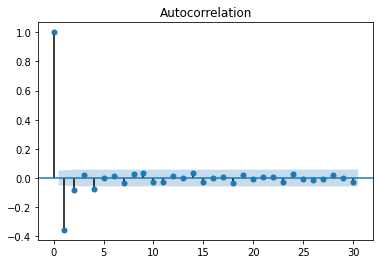

In [ ]:
acf = plot_acf(target.diff()[1:], lags=30)

In [ ]:
model = ARIMA(target, order=(9,1,4))
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyboardInterrupt: ignored

In [ ]:
prediction = model_fit.predict(start=len(target)-len(test_target), end=len(target))

In [ ]:
f = plot_preds(prediction.diff(-1)[:-1].values, test_target.values)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#print('previous item baseline MSE |', mean_squared_error(test_target.values, test_dataset.X[:, 0]))
print('prediction MSE             |', mean_squared_error(test_target, prediction.diff(-1)[:-1].values))